# VGG16 Spatial Action recognition

In [1]:
from prelude import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import transform, filter
import sys, pylab, operator, csv
import util
import os
import urllib
import imageio
import beoid
import itertools
import skimage.io
import caffe
caffe.set_mode_gpu()

import cnn_utils
pylab.rcParams['figure.figsize'] = (6.0, 6.0)

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
model_root_path = "/home/will/nets/vgg_16_ucf101/"
model_name = "cuhk_action_spatial_vgg_16_split1"

deploy_prototxt_path = os.path.join(model_root_path, model_name + "_deploy.prototxt")
caffemodel_path = os.path.join(model_root_path, model_name + ".caffemodel")


net = caffe.Net(deploy_prototxt_path,
                caffemodel_path,
                caffe.TEST)

# The very last layer in the network (pre loss layer)
topLayerName = 'fc8'
topBlobName = net.top_names[topLayerName][0]
secondTopLayerName = 'fc7'
secondTopBlobName = net.top_names[secondTopLayerName][0]

# This is the layer we'll stop at when excitation backpropping
outputLayerName = 'pool3'

In [4]:
cnn_utils.print_layer_shapes(net)

Layer shapes (output)

data      : [(1, 3, 224, 224)]
conv1_1   : [(1, 64, 224, 224)]
relu1_1   : [(1, 64, 224, 224)]
conv1_2   : [(1, 64, 224, 224)]
relu1_2   : [(1, 64, 224, 224)]
pool1     : [(1, 64, 112, 112)]
conv2_1   : [(1, 128, 112, 112)]
relu2_1   : [(1, 128, 112, 112)]
conv2_2   : [(1, 128, 112, 112)]
relu2_2   : [(1, 128, 112, 112)]
pool2     : [(1, 128, 56, 56)]
conv3_1   : [(1, 256, 56, 56)]
relu3_1   : [(1, 256, 56, 56)]
conv3_2   : [(1, 256, 56, 56)]
relu3_2   : [(1, 256, 56, 56)]
conv3_3   : [(1, 256, 56, 56)]
relu3_3   : [(1, 256, 56, 56)]
pool3     : [(1, 256, 28, 28)]
conv4_1   : [(1, 512, 28, 28)]
relu4_1   : [(1, 512, 28, 28)]
conv4_2   : [(1, 512, 28, 28)]
relu4_2   : [(1, 512, 28, 28)]
conv4_3   : [(1, 512, 28, 28)]
relu4_3   : [(1, 512, 28, 28)]
pool4     : [(1, 512, 14, 14)]
conv5_1   : [(1, 512, 14, 14)]
relu5_1   : [(1, 512, 14, 14)]
conv5_2   : [(1, 512, 14, 14)]
relu5_2   : [(1, 512, 14, 14)]
conv5_3   : [(1, 512, 14, 14)]
relu5_3   : [(1, 512, 14, 14)]
poo

In [39]:
def crop(image, size):
    old_width = image.shape[0]
    new_width = size[0]
    assert old_width >= new_width
    
    old_height = image.shape[1]
    new_height = size[1]
    assert old_height >= new_height
    
    horizontal_crop = np.ceil((old_width - new_width) / 2)
    vertical_crop = np.ceil((old_height - new_height) / 2)
    
    return image[
        horizontal_crop:-horizontal_crop,
        vertical_crop:-vertical_crop
    ].reshape(*new_size)

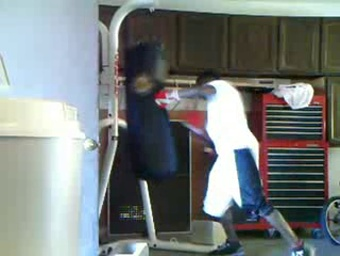

In [36]:
data_root = "/home/will/thesis/generated/ucf101/temporal/test-1/frames/"
image_path = os.path.join(data_root, "v_BoxingPunchingBag_g07_c04/frame000005.jpg")
                        
input_image = caffe.io.load_image(image_path)
skimage.io.Image(input_image)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


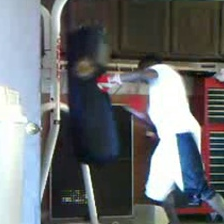

In [41]:
new_size = (224, 224, 3)
image = crop(input_image, new_size)

skimage.io.Image(image)

In [42]:
image.shape

(224, 224, 3)

In [50]:
eb = cnn_utils.ExcitationBackprop(net, 'fc8', 'fc7', 'pool3')
transformer = cnn_utils.imagenet_transformer(net)
preprocessed_image = transformer.preprocess('data', image)
net.blobs['data'].data[...] = preprocessed_image.reshape(1, 3, 224, 224)
out = net.forward(end = topLayerName)

class_count = 101
scores = net.blobs[eb.top_blob_name].data[0].reshape(class_count, -1).max(1).flatten() # pre-softmax scores
class_ids = scores.argsort()[-3:][::-1]

In [56]:

np.any(net.blobs['data'])

/home/will/thesis/lib/util.py:52: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ax[(i+1)/2, (i+1)%2].imshow(attMap, interpolation = 'bicubic')
/home/will/thesis/lib/util.py:53: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ax[(i+1)/2, (i+1)%2].set_title(tagName[i])
/home/will/thesis/lib/util.py:52: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ax[(i+1)/2, (i+1)%2].imshow(attMap, interpolation = 'bicubic')
/home/will/thesis/lib/util.py:53: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ax[(i+1)/2, (i+1)%2].set_title(tagName[i])
/home/will/thesis/lib/util.py:52: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ax[(i+1)/2, (i+1)%2].imshow(attMap, in

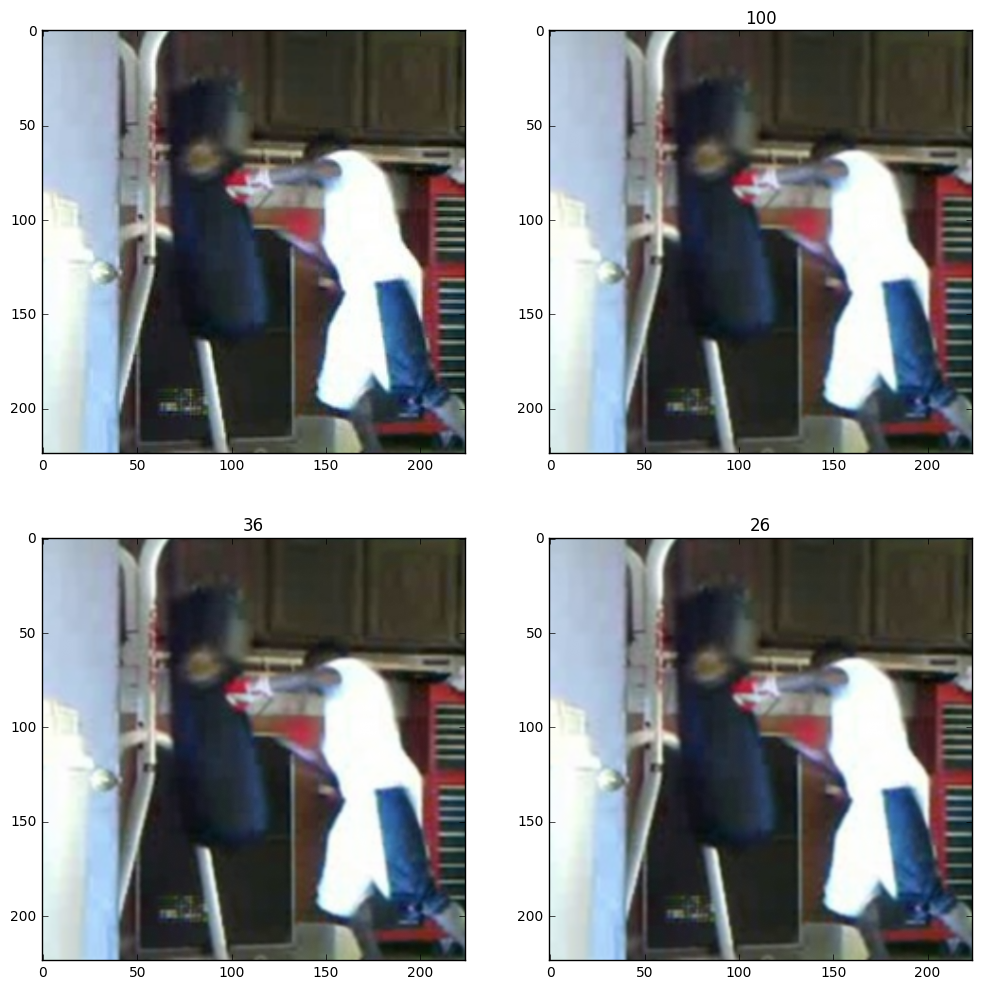

In [52]:
attMaps = []

for class_id in class_ids:
    attMap = eb.backprop(class_id)
    attMaps.append(attMap)
util.showAttMap(image, attMaps, class_ids, overlap=True)